In [1]:
%cd ~/team/gj/code

/opt/ml/team/gj/code


# Distribution

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import pickle
import yaml

from dataset import split_gt, load_sources, load_levels

plt.style.use('dark_background')

In [3]:
options = yaml.safe_load(open('/opt/ml/team/gj/code/configs/Default.yaml', 'r'))
sources = load_sources(options['data']['source_paths'])
levels = load_sources(options['data']['level_paths'])

In [4]:
source_to_name = {
    0: '출력물',
    1: '프린트',
}

level_to_name = {
    1: '초등',
    2: '중등',
    3: '고등',
    4: '대학',
    5: '대학 이상',
}

In [5]:
!ls /opt/ml/input/data/saving_model

basic.pth		      satrn_finetune_lr
log			      satrn_finetune_lr_test
satrn			      satrn_flex_local_aware_long
satrn_adaptive_2d	      satrn_flexible_size
satrn_adaptive_locality       satrn_large
satrn_basic		      satrn_large_test
satrn_between_ff	      satrn_locality_aware
satrn_between_ff_again	      satrn_many_head
satrn_between_ff_test	      satrn_many_head_test
satrn_criterion		      satrn_memory
satrn_criterion_test	      satrn_memory_test
satrn_cstr		      satrn_model_save
satrn_cstr_test		      satrn_multi_sample_dropout
satrn_cur_best_long	      satrn_multi_sample_dropout_test
satrn_cur_best_long_test      satrn_new_baseline
satrn_curr		      satrn_new_baseline_test
satrn_curr_diff_lrs	      satrn_reverse
satrn_curr_longer_test	      satrn_separable_cnn_test
satrn_debug_code	      satrn_share
satrn_decoder_mixed	      satrn_stn
satrn_decoder_mixed2	      satrn_stn_test
satrn_decoder_mixed_256       satrn_test
satrn_decoder_mixed_256_3     satrn_tf_0
satrn_decoder_mixed_256_

In [6]:
import torch
from checkpoint import load_checkpoint
from flags import Flags
import random
from torchvision import transforms
import utils
from utils import get_network
from dataset import LoadDataset, SizeBatchSampler, collate_batch, PAD
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from train_method import id_to_string

from torch.cuda.amp import (
    GradScaler, 
    autocast,
)

In [7]:
checkpoint_name = "/opt/ml/input/data/saving_model/satrn_debug_code/checkpoints/best.pth"

In [8]:
is_cuda = torch.cuda.is_available()
checkpoint = load_checkpoint(checkpoint_name, cuda=is_cuda)
options, _ = Flags(checkpoint["configs"]).get()
torch.manual_seed(options.seed)
random.seed(options.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
def get_dataset(paths):
    data = []
    for i, path in enumerate(paths):
        data_from_file = split_gt(path)
        data += data_from_file
        print(f'From {path}')
        print(f'Val +:\t{len(data_from_file)}')
    return data

dataset = get_dataset(options.data.test)
len(dataset)

From /opt/ml/input/data/train_dataset/test_gt_s:0_l:1.txt
Val +:	750
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:2.txt
Val +:	6458
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:3.txt
Val +:	1847
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:4.txt
Val +:	831
From /opt/ml/input/data/train_dataset/test_gt_s:0_l:5.txt
Val +:	114
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:1.txt
Val +:	1951
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:2.txt
Val +:	2248
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:3.txt
Val +:	4910
From /opt/ml/input/data/train_dataset/test_gt_s:1_l:4.txt
Val +:	891


20000

In [16]:
hardware = "cuda" if is_cuda else "cpu"
device = torch.device(hardware)
print("--------------------------------")
print("Running {} on device {}\n".format(options.network, device))

model_checkpoint = checkpoint["model"]
if model_checkpoint:
    print(
        "[+] Checkpoint\n",
        "Resuming from epoch : {}\n".format(checkpoint["epoch"]),
    )


if options.data.flexible_image_size:
    transformed = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
else:
    transformed = transforms.Compose(
        [
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ]
    )

# random.shuffle(wrong_data)
# random.shuffle(correct_data)
# data = wrong_data[:1]
# data = correct_data[:1]
valid_dataset = LoadDataset(
    dataset, options.data.token_paths, sources=sources,
    levels=levels, crop=options.data.crop,
    transform=transformed, rgb=options.data.rgb,
    max_resolution=options.input_size.height * options.input_size.width,
    is_flexible=options.data.flexible_image_size,
    is_reverse=options.data.is_reverse,
    apply_clihe=False,
    rotate_img=True,
)

valid_sampler = SizeBatchSampler(valid_dataset, 36, is_random=True)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_sampler=valid_sampler,
    num_workers=4,
    collate_fn=collate_batch,
)

--------------------------------
Running SATRN on device cuda

[+] Checkpoint
 Resuming from epoch : 10



  0%|          | 0/20000 [00:00<?, ?it/s]

In [12]:
for i in range(0, 20000):
    h, w = valid_dataset.get_shape(i)
    if h > w:
        break

In [13]:
i

162

In [17]:
valid_dataset[i]['image'][0].shape

torch.Size([64, 256])

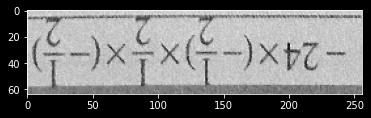

In [18]:
plt.imshow(valid_dataset[i]['image'][0], cmap='gray')

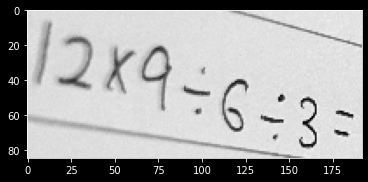

In [97]:
plt.imshow(valid_dataset[i]['image'][0], cmap='gray')

In [11]:
# model = get_network(
#     options.network,
#     options,
#     checkpoint_name,
#     torch.device('cuda'),
#     valid_dataset,
# )
# model.eval()
# print()

In [14]:
# model

In [15]:
# train = False
# data_loader = valid_data_loader
# use_amp=options.use_amp and device.type == 'cuda'
# epoch_text = ''
# teacher_forcing_ratio = 0

# correct = []
# wrong = []
    
# # Disables autograd during validation mode
# torch.set_grad_enabled(False)

# model.eval()

# idx = 0
# with tqdm(
#     desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
#     total=len(data_loader.dataset),
#     dynamic_ncols=True,
#     leave=False,
# ) as pbar:
#     for d in data_loader:
#         input = d["image"].to(device)

#         # The last batch may not be a full batch
#         curr_batch_size = len(input)
#         expected = d["truth"]["encoded"].to(device)
#         levels_expected = d['level'].to(device)
#         sources_expected = d['source'].to(device)

#         # Replace -1 with the PAD token
#         expected[expected == -1] = data_loader.dataset.token_to_id[PAD]

#         with autocast(enabled=use_amp):
#             outputs_dict= model(input, expected, train, teacher_forcing_ratio, return_attn=True)
#             output = outputs_dict['out']
#             decoded_values = output.transpose(1, 2)
#             _, sequence = torch.topk(decoded_values, 1, dim=1)
#             sequence = sequence.squeeze(1)

#         pbar.update(curr_batch_size)

#         expected = id_to_string(expected, data_loader, do_eval=1)
#         sequence = id_to_string(sequence, data_loader, do_eval=1)
        
#         for i in range(curr_batch_size):
#             id = int(d['path'][i].split('/')[-1].split('_')[1].split('.')[0])
#             ex = expected[i]
#             sq = sequence[i]
#             same = ex == sq
#             path = d['path'][i]
#             image = d['image'][i]
#             level = d['level'][i]
#             source = d['source'][i]
#             ex_len = len(ex.split())
#             pred_len = len(sq.split())
            
#             cur_item = {
#                 'id': id,
#                 'correct': same,
#                 'expected': ex,
#                 'sequence': sq,
#                 'level': level,
#                 'source': source,
#                 'path': path,
#                 'ex_len': ex_len,
#                 'pred_len': pred_len,
#             }
            
#             if same:
#                 correct.append(cur_item)
#             else:
#                 wrong.append(cur_item)
    
# print('done')

In [16]:
# saving = {
#     'correct': correct,
#     'wrong': wrong,
# }

# save_root = '/opt/ml/team/gj/notebooks/save'
# name = f'{checkpoint_name.split("/")[-3]}'

# save_name = f'{save_root}/{name}'

# pickle.dump(saving, open(save_name, 'wb'))

In [17]:
# name = f'{checkpoint_name.split("/")[-3]}_all'
# name

In [18]:
!ls /opt/ml/team/gj/notebooks/save

satrn_criterion      satrn_cur_best_long_all  satrn_reverse
satrn_cur_best_long  satrn_many_head


In [19]:
# normal = pickle.load(open('/opt/ml/team/gj/notebooks/save/satrn_criterion', 'rb'))
# rev = pickle.load(open('/opt/ml/team/gj/notebooks/save/satrn_reverse', 'rb'))
best = pickle.load(open('/opt/ml/team/gj/notebooks/save/satrn_cur_best_long', 'rb'))
# multi_head = pickle.load(open('/opt/ml/team/gj/notebooks/save/satrn_many_head', 'rb'))

In [20]:
# normal_dict = {x['id']: x for x in normal['wrong'] + normal['correct']}
# rev_dict = {x['id']: x for x in rev['wrong'] + rev['correct']}
best_dict = {x['id']: x for x in best['wrong'] + best['correct']}
# multi_head_dict = {x['id']: x for x in multi_head['wrong'] + multi_head['correct']}

In [21]:
# normal_wrong_ids = set(x['id'] for x in normal['wrong'])
# rev_wrong_ids = set(x['id'] for x in rev['wrong'])
best_wrong_ids = set(x['id'] for x in best['wrong'])
# multi_head_wrong_ids = set(x['id'] for x in multi_head['wrong'])

In [22]:
import torch
from checkpoint import load_checkpoint
from flags import Flags
import random
from torchvision import transforms
import utils
from utils import get_network
from dataset import LoadDataset, SizeBatchSampler, collate_batch, PAD
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from train_method import id_to_string

from torch.cuda.amp import (
    GradScaler, 
    autocast,
)

In [23]:
import skimage.transform

In [24]:
!ls /opt/ml/input/data/saving_model/

log			      satrn_flex_local_aware_long
satrn			      satrn_flexible_size
satrn_adaptive_2d	      satrn_large
satrn_adaptive_locality       satrn_large_test
satrn_basic		      satrn_locality_aware
satrn_between_ff	      satrn_many_head
satrn_between_ff_test	      satrn_many_head_test
satrn_criterion		      satrn_memory
satrn_criterion_test	      satrn_model_save
satrn_cstr		      satrn_multi_sample_dropout
satrn_cstr_test		      satrn_multi_sample_dropout_test
satrn_cur_best_long	      satrn_new_baseline
satrn_cur_best_long_test      satrn_new_baseline_test
satrn_curr		      satrn_reverse
satrn_curr_diff_lrs	      satrn_separable_cnn_test
satrn_curr_longer_test	      satrn_share
satrn_debug_code	      satrn_stn
satrn_decoder_mixed	      satrn_stn_test
satrn_decoder_mixed2	      satrn_test
satrn_decoder_mixed_256       satrn_tf_0
satrn_decoder_mixed_256_3     satrn_tf_1
satrn_decoder_mixed_256_4     satrn_tf_scheduler
satrn_decoder_mixed_256_6     satrn_tube
satrn_decoder_mixed_256_test

In [25]:
checkpoint = "/opt/ml/input/data/saving_model/satrn_debug_code/checkpoints/best.pth"

In [26]:
!ls /opt/ml/input/data/saving_model/satrn_debug_code/checkpoints/best.pth

/opt/ml/input/data/saving_model/satrn_debug_code/checkpoints/best.pth


In [27]:
is_cuda = torch.cuda.is_available()
checkpoint = load_checkpoint(checkpoint, cuda=is_cuda)
options, _ = Flags(checkpoint["configs"]).get()
torch.manual_seed(options.seed)
random.seed(options.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [28]:
# load_checkpoint(checkpoint, cuda=is_cuda)

In [29]:
def show_heatmap(data, checkpoint, layer=2, mult=8):
    is_cuda = torch.cuda.is_available()
    checkpoint = load_checkpoint(checkpoint, cuda=is_cuda)
    options, _ = Flags(checkpoint["configs"]).get()
    torch.manual_seed(options.seed)
    random.seed(options.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    hardware = "cuda" if is_cuda else "cpu"
    device = torch.device(hardware)
    print("--------------------------------")
    print("Running {} on device {}\n".format(options.network, device))

    model_checkpoint = checkpoint["model"]
    if model_checkpoint:
        print(
            "[+] Checkpoint\n",
            "Resuming from epoch : {}\n".format(checkpoint["epoch"]),
        )


    if options.data.flexible_image_size:
        transformed = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
    else:
        transformed = transforms.Compose(
            [
                transforms.Resize((options.input_size.height, options.input_size.width)),
                transforms.ToTensor(),
            ]
        )
    
    valid_dataset = LoadDataset(
        data, options.data.token_paths, sources=sources,
        levels=levels, crop=options.data.crop,
        transform=transformed, rgb=options.data.rgb,
        max_resolution=options.input_size.height * options.input_size.width,
        is_flexible=options.data.flexible_image_size,
        is_reverse=options.data.is_reverse,
    )

    valid_sampler = SizeBatchSampler(valid_dataset, 16, is_random=True)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_sampler=valid_sampler,
        num_workers=0,
        collate_fn=collate_batch,
    )
    
    model = get_network(
        options.network,
        options,
        model_checkpoint,
        device,
        valid_dataset,
    )
    model.eval()
    
    train = False
    data_loader = valid_data_loader
    use_amp=options.use_amp and device.type == 'cuda'
    epoch_text = ''
    teacher_forcing_ratio = 0

    # Disables autograd during validation mode
    torch.set_grad_enabled(False)

    model.eval()
    return model

    with tqdm(
        desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
        total=len(data_loader.dataset),
        dynamic_ncols=True,
        leave=False,
    ) as pbar:
        for d in data_loader:
            input = d["image"].to(device)

            # The last batch may not be a full batch
            curr_batch_size = len(input)
            expected = d["truth"]["encoded"].to(device)
            levels_expected = d['level'].to(device)
            sources_expected = d['source'].to(device)

            # Replace -1 with the PAD token
            expected[expected == -1] = data_loader.dataset.token_to_id[PAD]

            with autocast(enabled=use_amp):
                outputs_dict= model(input, expected, train, teacher_forcing_ratio, return_attn=True)
                output = outputs_dict['out']
                decoded_values = output.transpose(1, 2)
                _, sequence = torch.topk(decoded_values, 1, dim=1)
                sequence = sequence.squeeze(1)

            pbar.update(curr_batch_size)

    expected = id_to_string(expected, data_loader)
    sequence = id_to_string(sequence, data_loader)
    
    cur_idx = 0
    o = outputs_dict['out'][cur_idx]
    er = outputs_dict['enc_result'][cur_idx]
    at1 = outputs_dict['attns_1']
    at2 = outputs_dict['attns_2']
    im = d['image'][cur_idx]
    ex = expected[cur_idx]
    se = sequence[cur_idx]

    h, w, _ = er.shape
    cat1 = [x.squeeze(0).squeeze(1) for x in at1]
    cat2 = [x.squeeze(0).squeeze(1).reshape(-1, h, w).sum(0) for x in at2]
    
    print(f'Expected: {ex[6:]}')
    print(f'Sequence: {se}')
    fig = plt.figure(figsize=(20, 20))
    img = Image.open(d['path'][0])
    plt.imshow(img)
    plt.show()
    
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(im.squeeze(0), cmap='gray')
    plt.show()
    
    ser = skimage.transform.resize(er, (mult*h, mult*w, 1))
    # ser = er.sum(-1)
    ser = (ser - ser.min()) / (ser.max() - ser.min())
    # ser = ser.repeat(8, 0).repeat(8, 1)
#     ser = er.sum(-1)
#     ser = (ser - ser.min()) / (ser.max() - ser.min())
#     ser = ser.repeat(8, 0).repeat(8, 1)

    fig = plt.figure(figsize=(20, 20))
    plt.imshow(im.squeeze(0), cmap='gray')
    plt.imshow(ser, alpha=0.8, cmap='Reds')
    plt.show()
    
    latex = ['[BOS]'] + se.split()
    for idx in range(len(latex)-1):
        st = idx

        fig = plt.figure(figsize=(20, 10))
        plt.imshow(im.squeeze(0), cmap='gray')

        j = 3 * st + layer
        ser = (er * cat2[j][:, :, None])
        
        ser = skimage.transform.resize(ser, (mult*h, mult*w, 1))
        # ser = er.sum(-1)
        ser = (ser - ser.min()) / (ser.max() - ser.min())
        # ser = ser.repeat(8, 0).repeat(8, 1)
#         ser = ser.sum(-1)
#         ser = (ser - ser.min()) / (ser.max() - ser.min())
#         ser = ser.repeat(8, 0).repeat(8, 1)

        plt.imshow(ser, alpha=0.8, cmap='Reds')

        if idx + 1 < len(latex):
            next_c = latex[idx + 1]
        else:
            next_c = 'FIN'

        plt.title(f'{latex[idx]} -> {next_c}', size='x-large')
        plt.show()
        print()
    



In [30]:
len(best['wrong'])

4827

In [31]:
idx = 4000

In [32]:
idx -= 1

In [33]:
found = False
while not found:
    idx += 1
    cur_item = best['wrong'][idx]
    data = [
        [cur_item['path'], cur_item['expected']],
    ]
    w, h = Image.open(cur_item['path']).size
    if w >= h:
        found = True
    
layer = 2
print(idx)

checkpoint = "/opt/ml/input/data/saving_model/satrn_separable_cnn_test/checkpoints/best.pth"
d = show_heatmap(data, checkpoint, layer=layer)

4000
--------------------------------
Running SATRN on device cuda

[+] Checkpoint
 Resuming from epoch : 1



  0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
large/tot

0.5064817654139785

In [48]:
tot = 0
for name, param in d.named_parameters():
    tot += param.numel()

large = 0
mx = 0
mn = 0
cnt = 0
for name, param in d.named_parameters():
    cnt += 1
    mn += param.numel() / tot
    if param.numel() / tot >= 0.01:
        large += param.numel()
#     if param.numel() == 360000:
        
        print(f'{name}  \t{param.numel() / tot:.4f}')
        print(param.numel())
#         break
#     mx = max(mx, param.numel())
print(mx, mn/cnt)
    
#     if (param.numel() / tot) >= 0.05:
#         large += (param.numel() / tot)

encoder.shallow_cnn.trans1.conv.weight  	0.0103
93312
encoder.shallow_cnn.trans2_conv.weight  	0.0198
180000
encoder.attention_layers.0.feedforward_layer.layers.0.weight  	0.0198
180000
encoder.attention_layers.0.feedforward_layer.layers.4.point.weight  	0.0397
360000
encoder.attention_layers.0.feedforward_layer.layers.8.weight  	0.0198
180000
encoder.attention_layers.1.feedforward_layer.layers.0.weight  	0.0198
180000
encoder.attention_layers.1.feedforward_layer.layers.4.point.weight  	0.0397
360000
encoder.attention_layers.1.feedforward_layer.layers.8.weight  	0.0198
180000
encoder.attention_layers.2.feedforward_layer.layers.0.weight  	0.0198
180000
encoder.attention_layers.2.feedforward_layer.layers.4.point.weight  	0.0397
360000
encoder.attention_layers.2.feedforward_layer.layers.8.weight  	0.0198
180000
encoder.attention_layers.3.feedforward_layer.layers.0.weight  	0.0198
180000
encoder.attention_layers.3.feedforward_layer.layers.4.point.weight  	0.0397
360000
encoder.attention_la

In [41]:
360000/600

600.0

In [39]:
tot/25327740

0.35806814978359697

In [66]:
large

0.7386956481592628

In [69]:
tot = 0
for name, param in d.named_parameters():
    tot += param.numel()

large = 0
for name, param in d.named_parameters():
    if param.numel() / tot >= 0.05:
        print(f'{name}  \t{param.numel() / tot:.4f}')
        print(param.numel())
    if (param.numel() / tot) >= 0.05:
        large += (param.numel() / tot)

encoder.attention_layers.0.feedforward_layer.layers.4.weight  	0.1231
3240000
encoder.attention_layers.1.feedforward_layer.layers.4.weight  	0.1231
3240000
encoder.attention_layers.2.feedforward_layer.layers.4.weight  	0.1231
3240000
encoder.attention_layers.3.feedforward_layer.layers.4.weight  	0.1231
3240000
encoder.attention_layers.4.feedforward_layer.layers.4.weight  	0.1231
3240000
encoder.attention_layers.5.feedforward_layer.layers.4.weight  	0.1231
3240000


In [74]:
180000/600/300

1.0

In [77]:
600 * 600  * 9

3240000

In [78]:
600 * 600 * 1

360000

In [ ]:
9 * 

In [73]:

for name, param in d.encoder.attention_layers.named_parameters():
    print(f'{name}  \t{param.numel() / tot:.4f}')
    print(param.numel())

0.attention_layer.q_linear.weight  	0.0034
88800
0.attention_layer.q_linear.bias  	0.0000
296
0.attention_layer.k_linear.weight  	0.0034
88800
0.attention_layer.k_linear.bias  	0.0000
296
0.attention_layer.v_linear.weight  	0.0034
88800
0.attention_layer.v_linear.bias  	0.0000
296
0.attention_layer.out_linear.weight  	0.0034
88800
0.attention_layer.out_linear.bias  	0.0000
300
0.attention_norm.weight  	0.0000
300
0.attention_norm.bias  	0.0000
300
0.feedforward_layer.layers.0.weight  	0.0068
180000
0.feedforward_layer.layers.1.weight  	0.0000
600
0.feedforward_layer.layers.1.bias  	0.0000
600
0.feedforward_layer.layers.4.weight  	0.1231
3240000
0.feedforward_layer.layers.5.weight  	0.0000
600
0.feedforward_layer.layers.5.bias  	0.0000
600
0.feedforward_layer.layers.8.weight  	0.0068
180000
0.feedforward_layer.layers.9.weight  	0.0000
300
0.feedforward_layer.layers.9.bias  	0.0000
300
0.feedforward_norm.weight  	0.0000
300
0.feedforward_norm.bias  	0.0000
300
1.attention_layer.q_linear.

In [71]:
3240000/600/9

600.0

In [68]:
d.encoder.attention_layers

ModuleList(
  (0): TransformerEncoderLayer(
    (attention_layer): MultiHeadAttention(
      (q_linear): Linear(in_features=300, out_features=296, bias=True)
      (k_linear): Linear(in_features=300, out_features=296, bias=True)
      (v_linear): Linear(in_features=300, out_features=296, bias=True)
      (attention): ScaledDotProductAttention(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (out_linear): Linear(in_features=296, out_features=300, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (attention_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (feedforward_layer): LocalityAwareFeedforward(
      (layers): Sequential(
        (0): Conv2d(300, 600, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.1, inplace=False)
        (4): Conv2d(600, 600, kernel_size=(3, 3), stride=(1, 1), paddi

In [29]:

found = False
while not found:
    cur_item = best['wrong'][idx]
    data = [
        [cur_item['path'], cur_item['expected']],
    ]
    w, h = Image.open(cur_item['path']).size
    if w >= h:
        found = True
    else:
        idx += 1
    
layer = 2
print(idx)

# checkpoint = "/opt/ml/input/data/saving_model/satrn_reverse/checkpoints/0010.pth"
# checkpoint = "/opt/ml/input/data/saving_model/satrn_criterion/checkpoints/best.pth"
checkpoint = "/opt/ml/input/data/saving_model/satrn_many_head/checkpoints/best.pth"
d = show_heatmap(data, checkpoint, layer=layer)
idx += 1

4002
--------------------------------
Running SATRN on device cuda

[+] Checkpoint
 Resuming from epoch : 10



  0%|          | 0/1 [00:00<?, ?it/s]

AttributeError: 'LoadDataset' object has no attribute 'shape_cache'

In [127]:
a = normal['wrong'][0]

In [131]:
a['expected']

'\\lim _ { x \\to a + } f \\left( \\left[ x \\right] \\right) = f \\left( a \\right) , \\lim _ { x \\to a - } f \\left( \\left[ x \\right] \\right) = f \\left( a - 1 \\right) '

In [154]:
check = []
for a in normal['wrong']:
    half_len = a['pred_len'] // 2
    exp_half = ' '.join(a['expected'].split()[:half_len])
    seq_half = ' '.join(a['sequence'].split()[:half_len])

    if exp_half == seq_half and a['ex_len'] <= 10:
        check.append(a)

In [155]:
len(check)

544

In [207]:
gt_txt = '/opt/ml/input/data/train_dataset/gt.txt'
gt_s = split_gt(gt_txt)

['/opt/ml/input/data/train_dataset/images/train_31005.jpg',
 '\\right) 4 \\sqrt { 3 } - \\sqrt { 2 4 } + 5 \\sqrt { 6 } = 4 \\sqrt { 3 } - 2 \\sqrt { 6 } + 5 \\sqrt { 6 }']

In [212]:
for found in gt_s:
#     if found[1] == '5 \times 1 1 = 5 5':
    if '25502' in found[0]:
        print('found')
        break
found

found


['/opt/ml/input/data/train_dataset/images/train_25502.jpg',
 '5 \\times 1 1 = 5 5']

In [86]:
input_copy = input.clone()

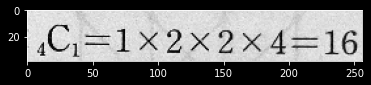

In [89]:
ftimg = input_copy.squeeze(0).squeeze(0)[:, 160:]
timg = (ftimg * 255).to(torch.int)
ctimg = timg.cpu().numpy()
plt.imshow(ctimg, cmap='gray')

In [52]:
import math
import torchvision.transforms as tf

In [65]:
def show_example(data, checkpoint):
    is_cuda = torch.cuda.is_available()
    checkpoint = load_checkpoint(checkpoint, cuda=is_cuda)
    options, _ = Flags(checkpoint["configs"]).get()
    torch.manual_seed(options.seed)
    random.seed(options.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    hardware = "cuda" if is_cuda else "cpu"
    device = torch.device(hardware)
    print("--------------------------------")
    print("Running {} on device {}\n".format(options.network, device))

    model_checkpoint = checkpoint["model"]
    if model_checkpoint:
        print(
            "[+] Checkpoint\n",
            "Resuming from epoch : {}\n".format(checkpoint["epoch"]),
        )


    if options.data.flexible_image_size:
        transformed = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
    else:
        transformed = transforms.Compose(
            [
                transforms.Resize((options.input_size.height, options.input_size.width)),
                transforms.ToTensor(),
            ]
        )
    
    valid_dataset = LoadDataset(
        data, options.data.token_paths, sources=sources,
        levels=levels, crop=options.data.crop,
        transform=transformed, rgb=options.data.rgb,
        max_resolution=options.input_size.height * options.input_size.width,
        is_flexible=options.data.flexible_image_size,
        is_reverse=options.data.is_reverse,
    )

    valid_sampler = SizeBatchSampler(valid_dataset, 16, is_random=True)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_sampler=valid_sampler,
        num_workers=0,
        collate_fn=collate_batch,
    )
    
    model = get_network(
        options.network,
        options,
        model_checkpoint,
        device,
        valid_dataset,
    )
    model.eval()
    
    train = False
    data_loader = valid_data_loader
    use_amp=options.use_amp and device.type == 'cuda'
    epoch_text = ''
    teacher_forcing_ratio = 0

    # Disables autograd during validation mode
    torch.set_grad_enabled(False)

    model.eval()

    with tqdm(
        desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
        total=len(data_loader.dataset),
        dynamic_ncols=True,
        leave=False,
    ) as pbar:
        for d in data_loader:
            input = d["image"].to(device)

            # The last batch may not be a full batch
            curr_batch_size = len(input)
            expected = d["truth"]["encoded"].to(device)
            levels_expected = d['level'].to(device)
            sources_expected = d['source'].to(device)

            # Replace -1 with the PAD token
            expected[expected == -1] = data_loader.dataset.token_to_id[PAD]

            with autocast(enabled=use_amp):
                output = model(input, expected, train, teacher_forcing_ratio, return_attn=False)
                decoded_values = output.transpose(1, 2)
                _, sequence = torch.topk(decoded_values, 1, dim=1)
                sequence = sequence.squeeze(1)

            pbar.update(curr_batch_size)

    expected = id_to_string(expected, data_loader)
    sequence = id_to_string(sequence, data_loader)
    
    cur_idx = 0
#     o = outputs_dict['out'][cur_idx]
#     er = outputs_dict['enc_result'][cur_idx]
    im = d['image'][cur_idx]
    ex = expected[cur_idx]
    se = sequence[cur_idx]

#     h, w, _ = er.shape
    
    
#     print(f'Expected: {ex[6:]}')
#     print(f'Sequence: {se}')
    return se, ex[6:], im, d['path'][0]

In [66]:
!ls /opt/ml/input/data/saving_model/satrn_criterion/checkpoints

best.pth


In [67]:
idx = 0

In [83]:
idx -= 1

316

satrn_criterion
--------------------------------
Running SATRN on device cuda

[+] Checkpoint
 Resuming from epoch : 10



  0%|          | 0/1 [00:00<?, ?it/s]

 (Validation):   0%|          | 0/1 [00:00<?, ?it/s]


satrn_cur_best_long
--------------------------------
Running SATRN on device cuda

[+] Checkpoint
 Resuming from epoch : 50



  0%|          | 0/1 [00:00<?, ?it/s]

 (Validation):   0%|          | 0/1 [00:00<?, ?it/s]

Diff
Y _ { 1 } , Y _ { 2 } \cdots Y _ { n } <EOS> 
satrn_criterion
Y Y Y Y Y Y } } } } _ _ _ { } <EOS> <EOS> <EOS> 
satrn_cur_best_long
Y Y Y _ _ \cdots Y _ \cdots \cdots \cdots \cdots \cdots \cdots \cdots \cdots \cdots \cdots 


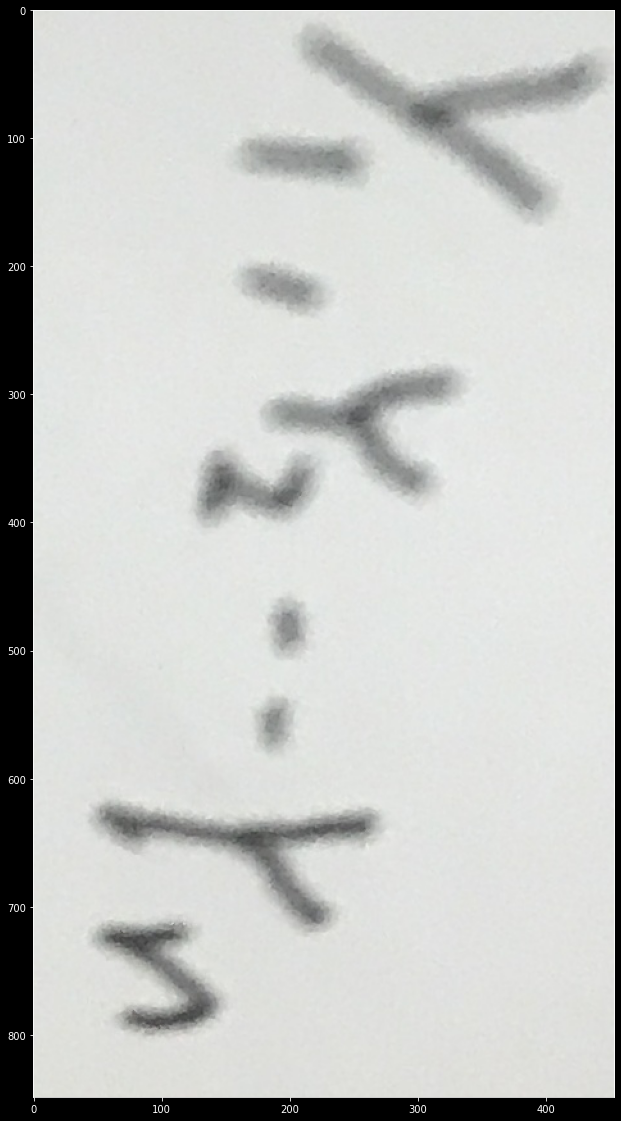

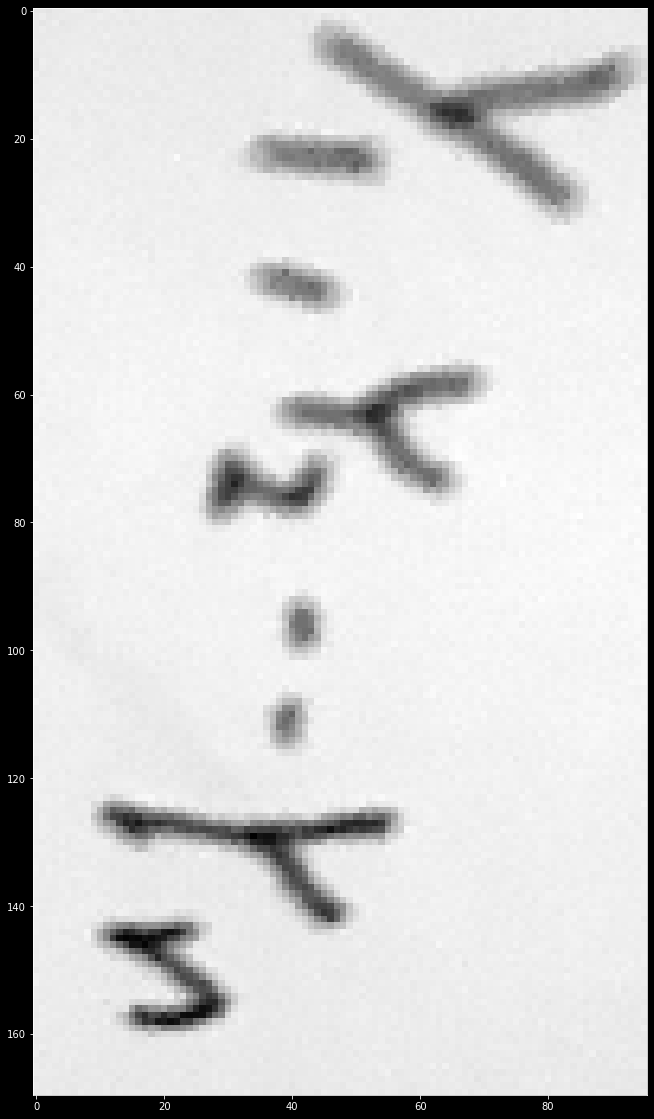

In [116]:
same = True
while same:
    found = False
    while not found:
        idx += 1
        cur_item = best['wrong'][idx]
        data = [
            [cur_item['path'], cur_item['expected']],
        ]
        w, h = Image.open(cur_item['path']).size
        if w < h:
            found = True

    layer = 2
    print(idx)

#     print('satrn_decoder_mixed2')
#     checkpoint = "/opt/ml/input/data/saving_model/satrn_decoder_mixed2/checkpoints/best.pth"
#     se1, ex, im, path = show_example(data, checkpoint)

    print()
    print('satrn_criterion')
    checkpoint = "/opt/ml/input/data/saving_model/satrn_criterion/checkpoints/best.pth"
    se2, ex, im, path = show_example(data, checkpoint)
    
    print()
    print('satrn_cur_best_long')
    checkpoint = "/opt/ml/input/data/saving_model/satrn_cur_best_long/checkpoints/best.pth"
    se3, ex, im, path = show_example(data, checkpoint)

#     if se1 != se2:
    print('Diff')
    print(ex)
#     print('satrn_decoder_mixed2')
#     print(se1)
    print('satrn_criterion')
    print(se2)
    print('satrn_cur_best_long')
    print(se3)

    fig = plt.figure(figsize=(20, 20))
    img = Image.open(path)
    plt.imshow(img)
    plt.show()

    fig = plt.figure(figsize=(20, 20))
    plt.imshow(im.squeeze(0), cmap='gray')
    plt.show()
    same = False
#     else:
#         print('Same')

In [86]:
!ls

__pycache__    dataset.py		  networks	train.py
checkpoint.py  default_config_style.yaml  notebooks	train_method.py
configs        flags.py			  rot.py	utils.py
curriculum.py  inference.py		  rot_model	wandb
data_tools     metrics.py		  scheduler.py
